In [161]:
import os
import re
import sys
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage
from skimage import io
from sklearn import preprocessing
from tqdm.notebook import tqdm, trange
import cv2
import pickle
from sklearn.preprocessing import StandardScaler

In [162]:
d_dir = (Path().cwd().parents[0].parents[0]).absolute()
data_dir = d_dir / "09_datasets"

p_dir = (Path().cwd().parents[0]).absolute()

In [163]:
mask_folder = data_dir / 'exported' / 'foll_masks'

In [164]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [165]:
import morph

In [166]:
def plot(data, ax, N=100, **kwargs):
    x = np.concatenate([data[:N], [data[0]]])
    y = np.concatenate([data[N:], [data[N]]])
    ax.plot(x, y, linewidth=2, **kwargs)
    ax.set_aspect('equal')
    # ax.set_xlim(-1.5, 1.5)
    # ax.set_ylim(-1.1, 1.1)
    ax.axis('off')

In [167]:
import math

def plot_point(point, angle, length, ax):
    '''
    point - Tuple (x, y)
    angle - Angle you want your end point at in degrees.
    length - Length of the line you want to plot.

    Will plot the line on a 10 x 10 plot.
    '''

    # unpack the first point
    x, y = point

    # find the end point
    endy = y + length * math.sin(angle)
    endx = x + length * math.cos(angle)

    # plot the points
    ax.plot([x, endx], [y, endy])

# Morphology clustering based on lymphoid structure

In [207]:
from scipy import stats
from sklearn import preprocessing
import anndata as ad
import scanpy as sc

In [208]:
save_path = p_dir / 'data' / 'morph' / 'outlinePCA.pkl'

outlinePCA = morph.OutlinePCA.load(save_path)

In [209]:
foll = outlinePCA.foll_weights - np.min( outlinePCA.foll_weights, axis=1)[:, np.newaxis]+1
gc = outlinePCA.gc_weights - np.min( outlinePCA.gc_weights, axis=1)[:, np.newaxis]+1

combined  = np.hstack([foll, gc])
ori_combined = np.hstack([ outlinePCA.foll_weights,  outlinePCA.gc_weights])

# Iterate throught the PCA components
for k in range(len(combined.T)):
    test = combined.T[k]
    test[test < 0] = 0.000000000001
    test, maxlog = stats.boxcox(test)
    test = np.asarray(test)
    combined.T[k] = (test - np.mean(test)) / np.std(test)

combined_norm = preprocessing.normalize(combined)

In [210]:
columns = [f'PCA_Foll_{i}' for i in range(1, 17)] + [f'PCA_GC_{i}' for i in range(1, 17)]

In [172]:
adata_pca = ad.AnnData(combined)
adata_pca.var_names = columns
sc.pp.neighbors(adata_pca)
sc.tl.umap(adata_pca)

# adjacency = sc._utils._choose_graph(adata_pca, obsp=None, neighbors_key=None)
# g = sc._utils.get_igraph_from_adjacency(adjacency)
# clustering = g.community_leiden(objective_function='modularity', weights='weight', resolution_parameter=0.8)
# adata_pca.obs['leiden'] = pd.Series(clustering.membership, dtype='category', index=adata_pca.obs.index)
sc.tl.leiden(adata_pca, resolution=0.8)

C:\Users\thu71\AppData\Local\Temp\ipykernel_57236\90711243.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_pca = ad.AnnData(combined_norm)


In [173]:
print(len(np.unique(adata_pca.obs['leiden'])))

8


C:\Users\thu71\Anaconda3\envs\snowflake\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


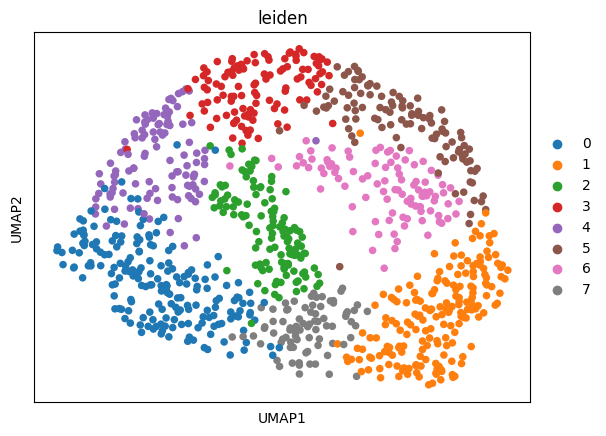

In [174]:
sc.pl.umap(adata_pca, color=['leiden'])


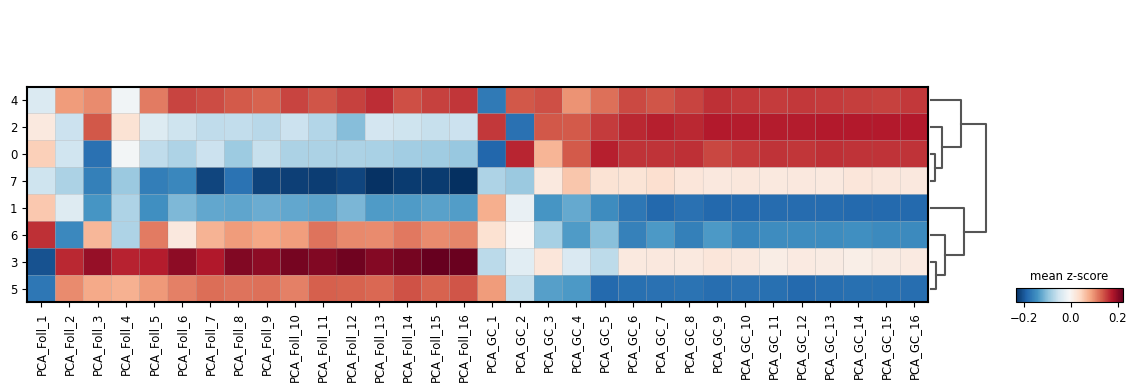

In [175]:
# Plot pca heatmap to show high low pca in each cluster
sc.pl.matrixplot(adata_pca, adata_pca.var_names, 'leiden', dendrogram=True,
                 colorbar_title='mean z-score', cmap='RdBu_r')


In [ ]:
# Plot pca heatmap to show high low pca in each cluster
sc.pl.heatmap(adata_pca, adata_pca.var_names, 'leiden', dendrogram=True, cmap='RdBu_r')


In [176]:
# Average representation by taking mean pca value in each cluster
clusters = adata_pca.obs['leiden']

centroids = {}
for cluster in clusters.cat.categories:
    subset = ori_combined[clusters == cluster]
    centroids[cluster] = np.mean(subset, axis=0)
    # centroids[cluster] = subset[2]
    
n_pca = 16
reconstructed_foll = {}
reconstructed_gc = {}
for k, v in centroids.items():
    inverse_pca_foll = outlinePCA.foll_pca.inverse_transform(v[:n_pca])
    inverse_pca_gc = outlinePCA.gc_pca.inverse_transform(v[n_pca:])
    
    reconstructed_foll[k] = inverse_pca_foll
    reconstructed_gc[k] = inverse_pca_gc


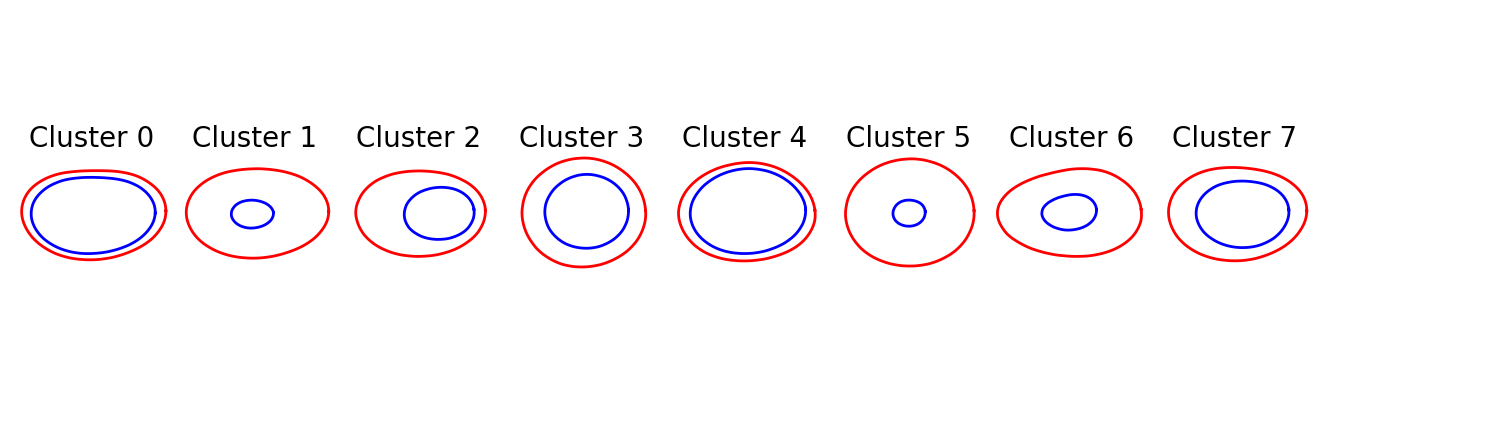

In [177]:
N_rows = 1
N_cols = 9
N = 120
figsize = (15,5)

## Reconstruction
fig, axes = plt.subplots(N_rows, N_cols, figsize=figsize, sharey=True, sharex=True)
for i, row in enumerate(axes):
    try:
        bd_foll_resampled = reconstructed_foll[str(i)]
        bd_gc_resampled = reconstructed_gc[str(i)]
        plot(bd_foll_resampled, row, N=N, color='r', alpha=1)
        # if gc_one_hot[i*N_rows+j] == 1:
        plot(bd_gc_resampled, row, N=N, color='b', alpha=1)
        label_props = {'size':20, 'horizontalalignment':'center', 'verticalalignment':'center'}
        row.set_title(f'Cluster {i}', **label_props)    
    except:
        row.axis('off')
plt.tight_layout(rect=[0, 0.03, 1, 0.90])
plt.subplots_adjust(wspace=0, hspace=0)


In [178]:
# add info
adata_pca.obs['id'] = outlinePCA.df.id.tolist()


In [179]:
# Covid mapping from patient id to covid. Covid = 1, Normal = 0
covid_dict = {'3': 'Negative', '5': 'Positive', '6': 'Positive', '8':'Positive',
             '11': 'Positive', '18': 'Negative', '21':'Negative', '22': 'Positive'}

adata_pca_nih = adata_pca[ids]
adata_pca_nih.obs['Dataset'] = adata_pca_nih.obs['id'].str.split('_').str[1]
adata_pca_nih.obs['COVID'] = adata_pca_nih.obs['Dataset'].str[1:].apply(lambda x: covid_dict.get(x,x))

C:\Users\thu71\AppData\Local\Temp\ipykernel_57236\762622498.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_pca_nih.obs['Dataset'] = adata_pca_nih.obs['id'].str.split('_').str[1]


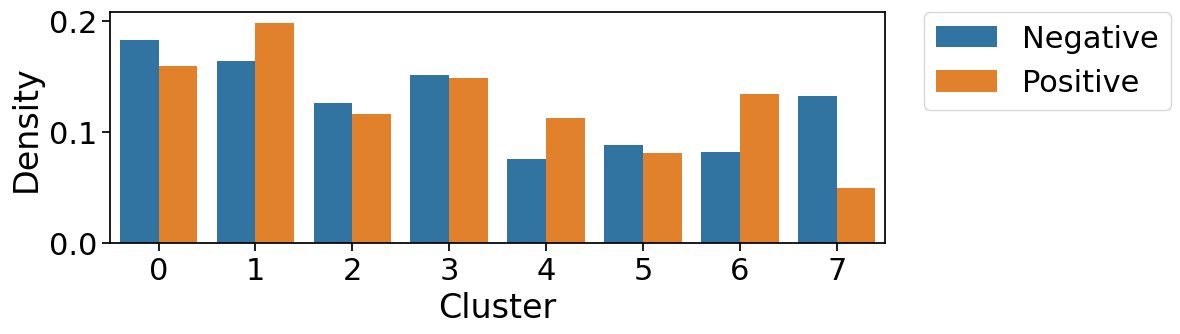

In [180]:
import seaborn as sns

# Get data
df_subset = adata_pca_nih.obs[['leiden', 'COVID']]
df_subset.columns = ['Cluster', 'Covid']
df_subset = df_subset.groupby(['Covid', 'Cluster']).size().reset_index()
df_subset.columns = ['Covid', 'Cluster',  'Count']
df_subset = df_subset.pivot_table(values='Count', index='Covid', columns='Cluster').reset_index()

df_subset.iloc[:,1:] = df_subset.iloc[:,1:].div(df_subset.iloc[:,1:].sum(1), axis=0)

df_melt = df_subset.melt(id_vars=['Covid'], value_name='Density')

# plot
x = 'Cluster'
y = 'Density'
hue = 'Covid'
with sns.plotting_context('notebook', font_scale=2):

    fig, ax = plt.subplots(figsize=(10,3))
    sns.barplot(data=df_melt, x=x, y=y, hue=hue)
    # plt.xticks(rotation = 25, ha="right")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()


## NIH 

In [181]:
ids = outlinePCA.df[outlinePCA.df.id.str.startswith('07')].index.tolist()

In [182]:
# Read only nih data
foll = outlinePCA.foll_weights - np.min( outlinePCA.foll_weights, axis=1)[:, np.newaxis]+1
gc = outlinePCA.gc_weights - np.min( outlinePCA.gc_weights, axis=1)[:, np.newaxis]+1
foll_nih = foll[ids]
gc_nih = gc[ids]

combined  = np.hstack([foll_nih, gc_nih])
ori_combined = np.hstack([ outlinePCA.foll_weights[ids],  outlinePCA.gc_weights[ids]])

# Iterate throught the PCA components
for k in range(len(combined.T)):
    test = combined.T[k]
    test[test < 0] = 0.000000000001
    test, maxlog = stats.boxcox(test)
    test = np.asarray(test)
    combined.T[k] = (test - np.mean(test)) / np.std(test)

combined_norm = preprocessing.normalize(combined)

In [183]:
columns = [f'PCA_Foll_{i}' for i in range(1, 17)] + [f'PCA_GC_{i}' for i in range(1, 17)]

In [198]:
adata_pca = ad.AnnData(combined)
adata_pca.var_names = columns
sc.pp.neighbors(adata_pca)
sc.tl.umap(adata_pca)

# adjacency = sc._utils._choose_graph(adata_pca, obsp=None, neighbors_key=None)
# g = sc._utils.get_igraph_from_adjacency(adjacency)
# clustering = g.community_leiden(objective_function='modularity', weights='weight', resolution_parameter=0.8)
# adata_pca.obs['leiden'] = pd.Series(clustering.membership, dtype='category', index=adata_pca.obs.index)
sc.tl.leiden(adata_pca)

C:\Users\thu71\AppData\Local\Temp\ipykernel_57236\474995933.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_pca = ad.AnnData(combined)


In [199]:
print(len(np.unique(adata_pca.obs['leiden'])))

9


C:\Users\thu71\Anaconda3\envs\snowflake\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


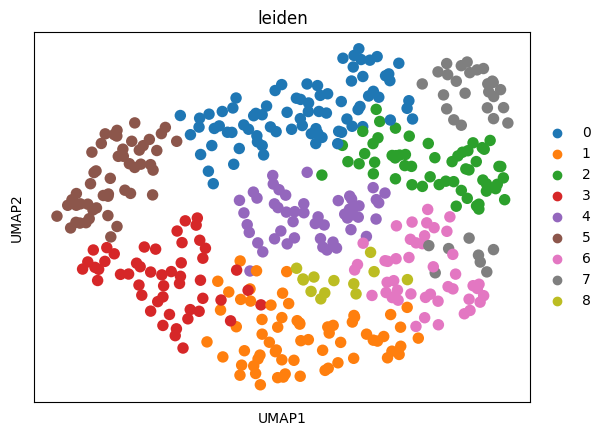

In [200]:
sc.pl.umap(adata_pca, color=['leiden'])


In [201]:
adata_pca

AnnData object with n_obs × n_vars = 442 × 32
    obs: 'leiden'
    uns: 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

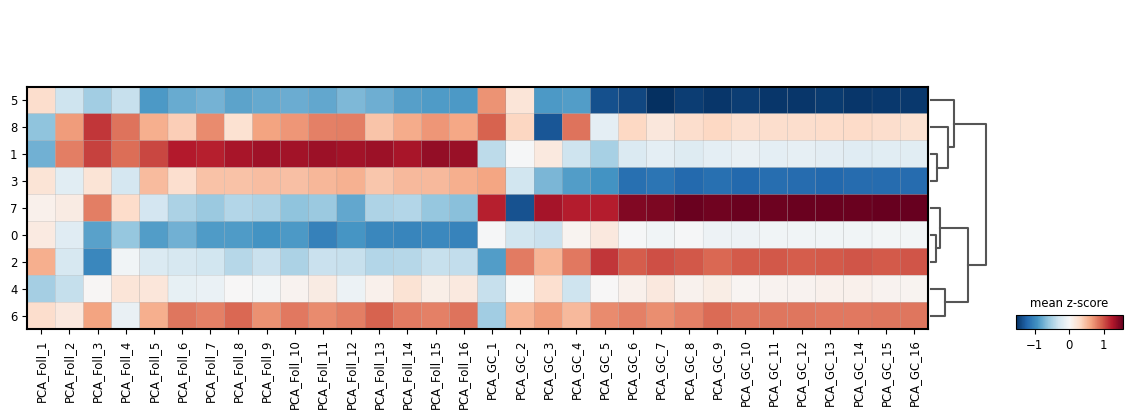

In [203]:
# Plot pca heatmap to show high low pca in each cluster
sc.pl.matrixplot(adata_pca, adata_pca.var_names, 'leiden', dendrogram=True,
                 colorbar_title='mean z-score', cmap='RdBu_r')


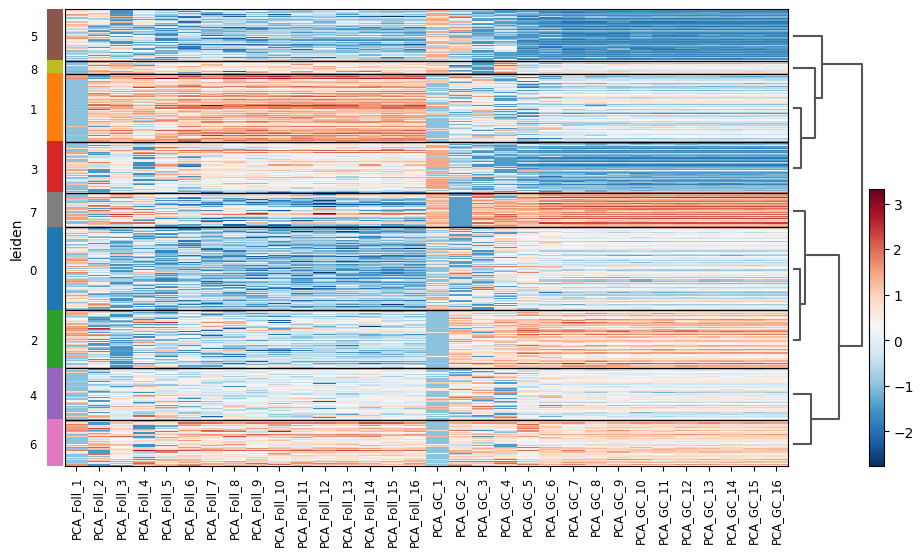

In [204]:
# Plot pca heatmap to show high low pca in each cluster
sc.pl.heatmap(adata_pca, adata_pca.var_names, 'leiden', dendrogram=True, cmap='RdBu_r')


In [205]:
# Average representation by taking mean pca value in each cluster
clusters = adata_pca.obs['leiden']

centroids = {}
for cluster in clusters.cat.categories:
    subset = ori_combined[clusters == cluster]
    centroids[cluster] = np.mean(subset, axis=0)
    # centroids[cluster] = subset[2]
    
n_pca = 16
reconstructed_foll = {}
reconstructed_gc = {}
for k, v in centroids.items():
    inverse_pca_foll = outlinePCA.foll_pca.inverse_transform(v[:n_pca])
    inverse_pca_gc = outlinePCA.gc_pca.inverse_transform(v[n_pca:])
    
    reconstructed_foll[k] = inverse_pca_foll
    reconstructed_gc[k] = inverse_pca_gc


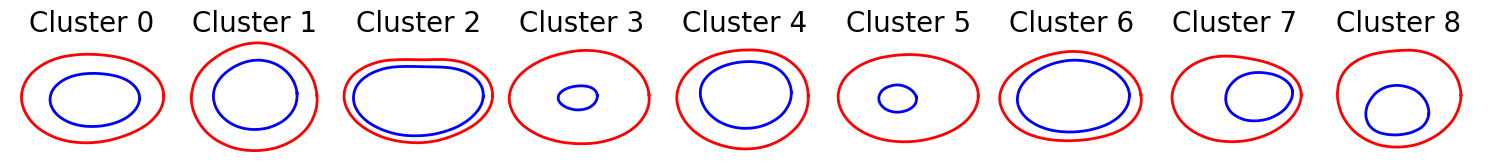

In [206]:
N_rows = 1
N_cols = 9
N = 120
figsize = (15,5)

## Reconstruction
fig, axes = plt.subplots(N_rows, N_cols, figsize=figsize, sharey=True, sharex=True)
for i, row in enumerate(axes):
    try:
        bd_foll_resampled = reconstructed_foll[str(i)]
        bd_gc_resampled = reconstructed_gc[str(i)]
        plot(bd_foll_resampled, row, N=N, color='r', alpha=1)
        # if gc_one_hot[i*N_rows+j] == 1:
        plot(bd_gc_resampled, row, N=N, color='b', alpha=1)
        label_props = {'size':20, 'horizontalalignment':'center', 'verticalalignment':'center'}
        row.set_title(f'Cluster {i}', **label_props)    
    except:
        row.axis('off')
plt.tight_layout(rect=[0, 0.03, 1, 0.90])
plt.subplots_adjust(wspace=0, hspace=0)


In [191]:
# add info
adata_pca.obs['id'] = outlinePCA.df.loc[ids].id.tolist()


In [192]:
# Covid mapping from patient id to covid. Covid = 1, Normal = 0
covid_dict = {'3': 'Negative', '5': 'Positive', '6': 'Positive', '8':'Positive',
             '11': 'Positive', '18': 'Negative', '21':'Negative', '22': 'Positive'}

adata_pca_nih = adata_pca
adata_pca_nih.obs['Dataset'] = adata_pca_nih.obs['id'].str.split('_').str[1]
adata_pca_nih.obs['COVID'] = adata_pca_nih.obs['Dataset'].str[1:].apply(lambda x: covid_dict.get(x,x))

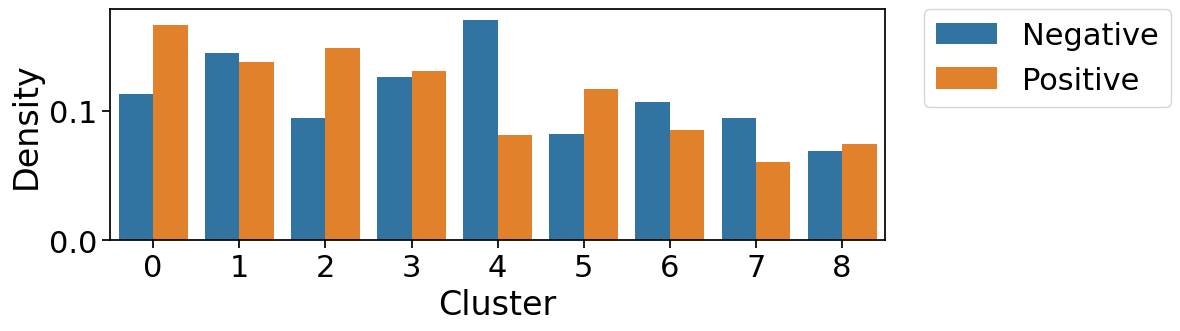

In [193]:
import seaborn as sns

# Get data
df_subset = adata_pca_nih.obs[['leiden', 'COVID']]
df_subset.columns = ['Cluster', 'Covid']
df_subset = df_subset.groupby(['Covid', 'Cluster']).size().reset_index()
df_subset.columns = ['Covid', 'Cluster',  'Count']
df_subset = df_subset.pivot_table(values='Count', index='Covid', columns='Cluster').reset_index()

df_subset.iloc[:,1:] = df_subset.iloc[:,1:].div(df_subset.iloc[:,1:].sum(1), axis=0)

df_melt = df_subset.melt(id_vars=['Covid'], value_name='Density')

# plot
x = 'Cluster'
y = 'Density'
hue = 'Covid'
with sns.plotting_context('notebook', font_scale=2):

    fig, ax = plt.subplots(figsize=(10,3))
    sns.barplot(data=df_melt, x=x, y=y, hue=hue)
    # plt.xticks(rotation = 25, ha="right")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()
